# 6. Time series analysis

### This script contains:

1. Import libraries & data
2. Subsetting, wrangling, and cleaning time-series data
3. Time-series analysis: decomposition
4. Testing for stationarity
5. Stationarising the data

## Import libraries & data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings 

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# display charts without having to call them

%matplotlib inline

In [3]:
# configure API key 

quandl.ApiConfig.api_key = 'toMt8qHq5Yb61Vd1PRVz'

In [4]:
# importing the Australian Inflation Rates (CPI) data

data = quandl.get('RATEINF/CPI_AUS')

In [5]:
data.head()

,Value
Date,
1948-09-30,3.7
1948-12-31,3.8
1949-03-31,3.9
1949-06-30,4.0
1949-09-30,4.1


In [6]:
data.shape

(294, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

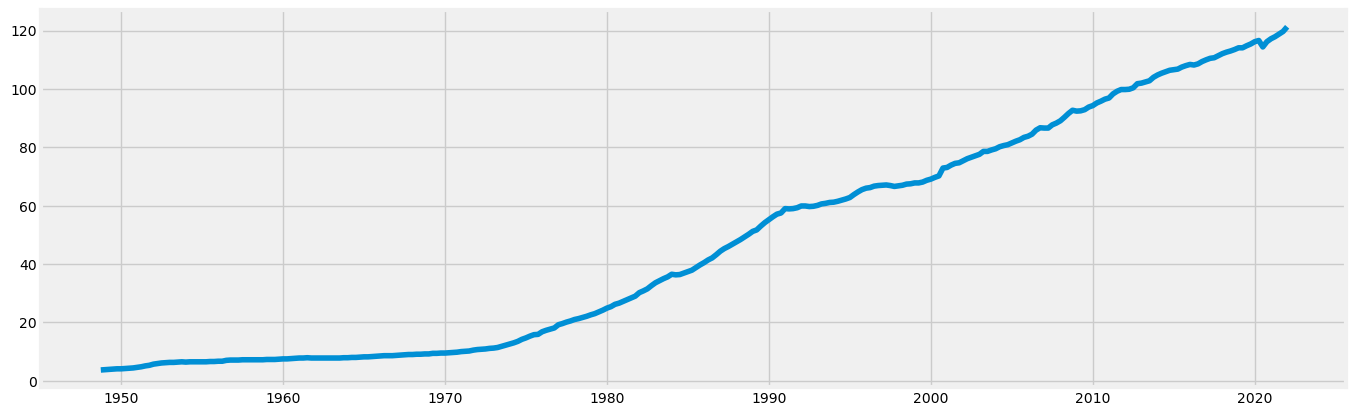

In [8]:
# plot the data 

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

## Subsetting, wrangling, and cleaning time-series data

In [9]:
# reset index so that you can use the 'date' column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1948-09-30,3.7
1,1948-12-31,3.8
2,1949-03-31,3.9
3,1949-06-30,4.0
4,1949-09-30,4.1


In [11]:
# creating a subset with data from 1980 onwards

data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01')]

In [12]:
data_sub.head()

,Date,Value
126,1980-03-31,25.4
127,1980-06-30,26.2
128,1980-09-30,26.6
129,1980-12-31,27.2
130,1981-03-31,27.8


In [13]:
data_sub.shape

(168, 2)

In [14]:
# re-set the 'date' column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date."
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-03-31,25.4
1980-06-30,26.2
1980-09-30,26.6
1980-12-31,27.2
1981-03-31,27.8


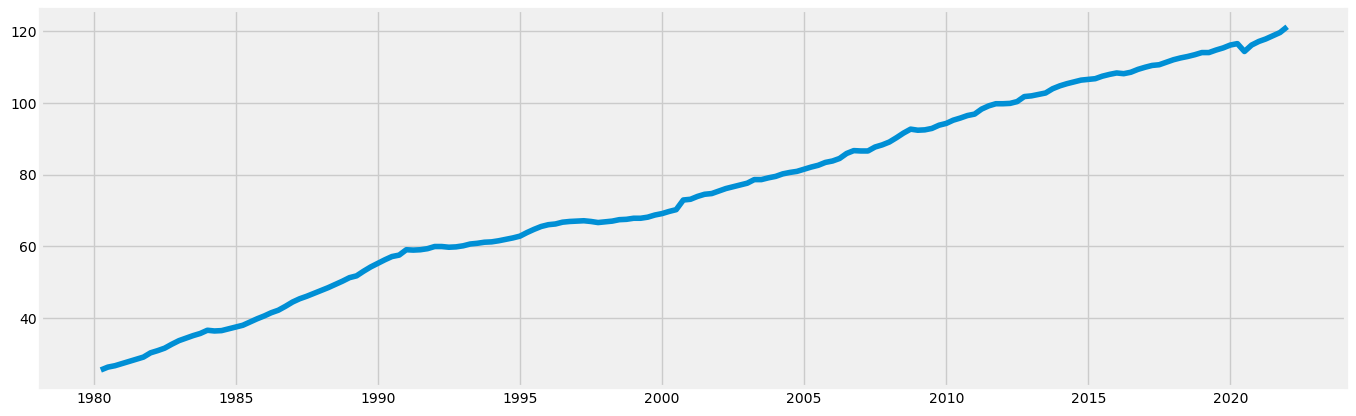

In [15]:
# plot the subset

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# creating a missing values subset

dups = data_sub[data_sub['Value'].isnull() == True]

# no dups

In [18]:
dups.head(168)

,Value
datetime,


## Time-series analysis: decomposition

In [19]:
# decompose the time series using an additive model (due to being linear)

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
# define a fixed size for all special charts

from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

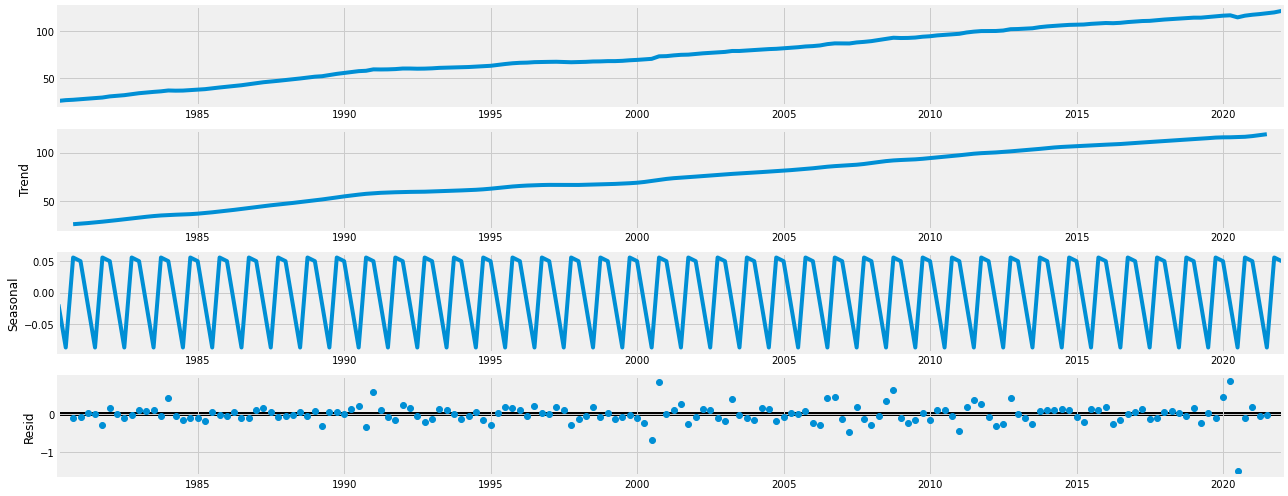

In [21]:
# plot the separate components

decomposition.plot()
plt.show()

## Testing for stationarity

In [22]:
# the adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): # define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.855057
p-value                          0.802413
Number of Lags Used              1.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


The test statistic is larger that the critical value (5%), so I can't reject the null hypothesis. Therefore, this test has confirmed that this data is non-stationary

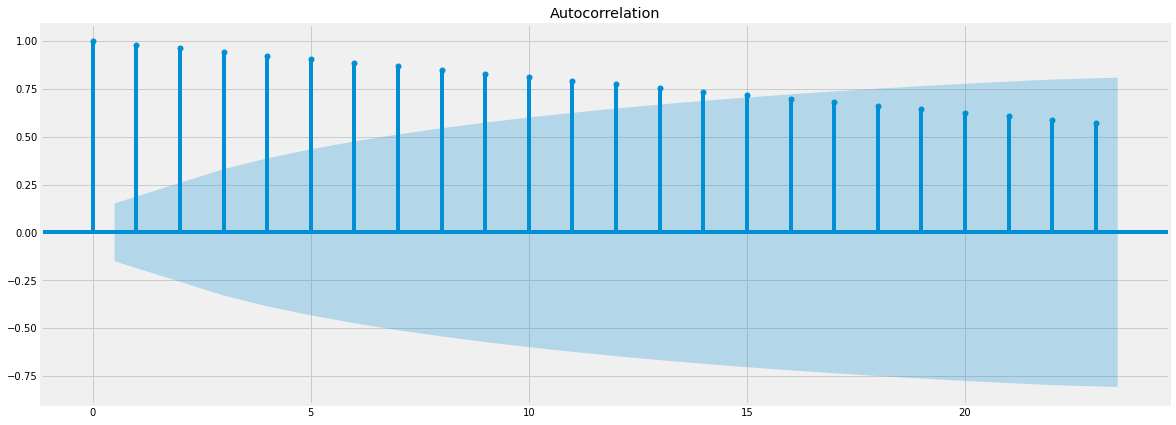

In [23]:
# check for autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # import of the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

This plot shows that the lags are significantly correlated with each other, therefore the data is confirmed as non-stationary

## Stationarising the data

In [24]:
# stationarising through differencing [value(new) = t - (t - 1)]
# df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

data_diff = data_sub - data_sub.shift(1)

In [25]:
# remove the missing values that came about as a result of the differencing
# need to remove these to run the Dickey-Fuller test

data_diff.dropna(inplace = True)

In [26]:
data_diff.head()

,Value
datetime,
1980-06-30,0.8
1980-09-30,0.4
1980-12-31,0.6
1981-03-31,0.6
1981-06-30,0.6


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

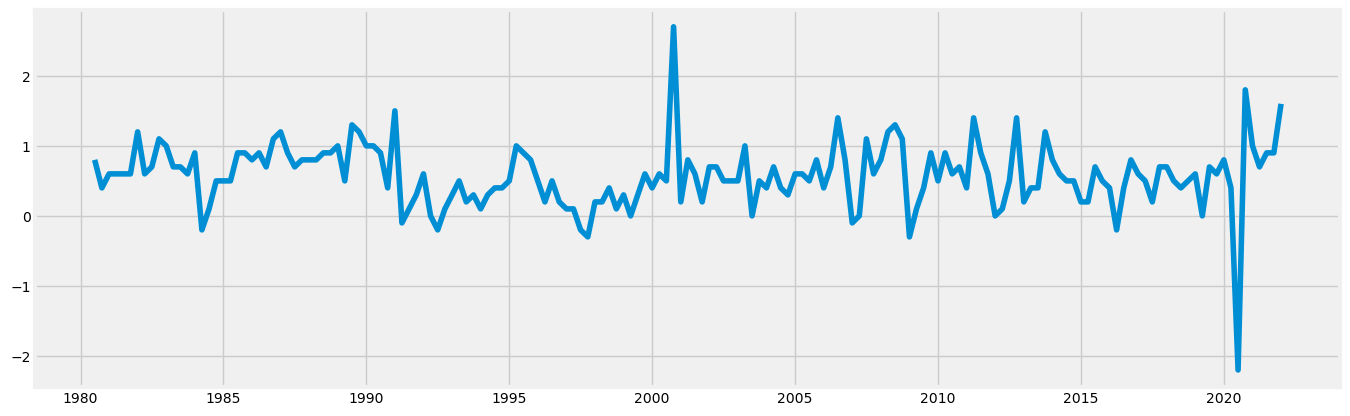

In [28]:
# check what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.099084e+01
p-value                        7.066317e-20
Number of Lags Used            0.000000e+00
Number of Observations Used    1.660000e+02
Critical Value (1%)           -3.470370e+00
Critical Value (5%)           -2.879114e+00
Critical Value (10%)          -2.576139e+00
dtype: float64


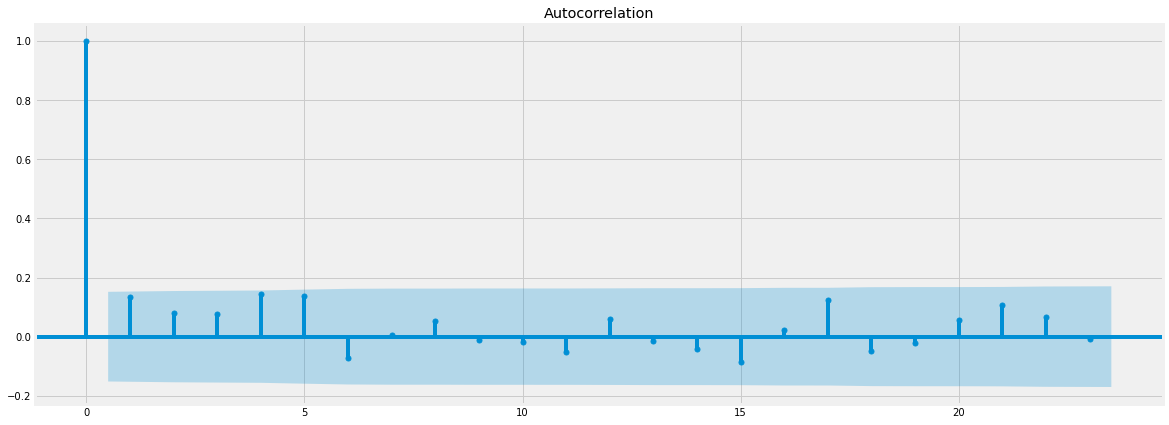

In [30]:
plot_acf(data_diff)
plt.show()

Although the test statistic is still larger than the critical value, and I still can't reject the null hypothesis, I do not have enough significant lags to conduct another autocorrelations test